### Effective Radius Comparison

Compare forward model with different wavelengths and reffs.

In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)

In [2]:
cloud_scatterer = at3d.util.load_from_csv('../data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt',
                                           density='lwc',origin=(0.0,0.0))

In [3]:
#load atmosphere
atmosphere = xr.open_dataset('../data/ancillary/AFGL_summer_mid_lat.nc')
#subset the atmosphere, choose only the bottom four km.
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 4.0]})
#merge the atmosphere and cloud z coordinates
merged_z_coordinate = at3d.grid.combine_z_coordinates([reduced_atmosphere,cloud_scatterer])

# define the property grid - which is equivalent to the base RTE grid
rte_grid = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          cloud_scatterer.z.data)

In [4]:
#finish defining microphysics because we can.

cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = at3d.size_distribution.gamma

cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


### TEST DIFFERENT WAVELENTHS

In [5]:
sensor_dicts = []
wavelengths = [.470, .550, .660, .865] 
sensor_zenith_list = [60.0, 0.0, 60.0]
sensor_azimuth_list = [65.0, 0.0, 65+180.0]
irradiance = [np.pi*at3d.util.planck_function(5800, wavelength) for wavelength in wavelengths]
relative_irradiance = irradiance/np.mean(irradiance)

for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
    sensor_dict = at3d.containers.SensorsDict()
    for wavelength in wavelengths:
        sensor_dict.add_sensor('MSPI', 
                at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                         altitude='TOA', stokes='I'))
    sensor_dicts.append(sensor_dict)

print(relative_irradiance)
print(wavelengths)

[1.1776641  1.16328816 1.00389872 0.65514902]
[0.47, 0.55, 0.66, 0.865]


In [6]:
mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

Save mie tables

In [7]:
# for wavelength in wavelengths:
#     mie_mono_tables[wavelength].to_netcdf(path='../mie_tables/' + str(wavelength) + '_mie_table.nc')

In [7]:
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(5.0,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)
optical_properties = optical_property_generator(cloud_scatterer_on_rte_grid)

In [8]:
# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

In [9]:
solvers_dict = at3d.containers.SolversDict()
# note we could set solver dependent surfaces / sources / numerical_config here
# just as we have got solver dependent optical properties.

for wavelength in sensor_dicts[0].get_unique_solvers():
    medium = {
        'cloud': optical_properties[wavelength],
        'rayleigh':rayleigh_scattering[wavelength]
     }
    config = at3d.configuration.get_config()
    solvers_dict.add_solver(
        wavelength,
        at3d.solver.RTE(
            numerical_params=config,
            surface=at3d.surface.lambertian(0.0),
            source=at3d.source.solar(wavelength, 0.5,0.0),
            medium=medium,
            num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
        )                   
    )


In [10]:
%%time
for sensor_dict in sensor_dicts:
    # solve the 4 RTEs in parallel AND get the measurements.
    sensor_dict.get_measurements(solvers_dict, n_jobs=4, verbose=True)

CPU times: user 9min 52s, sys: 879 ms, total: 9min 53s
Wall time: 2min 38s


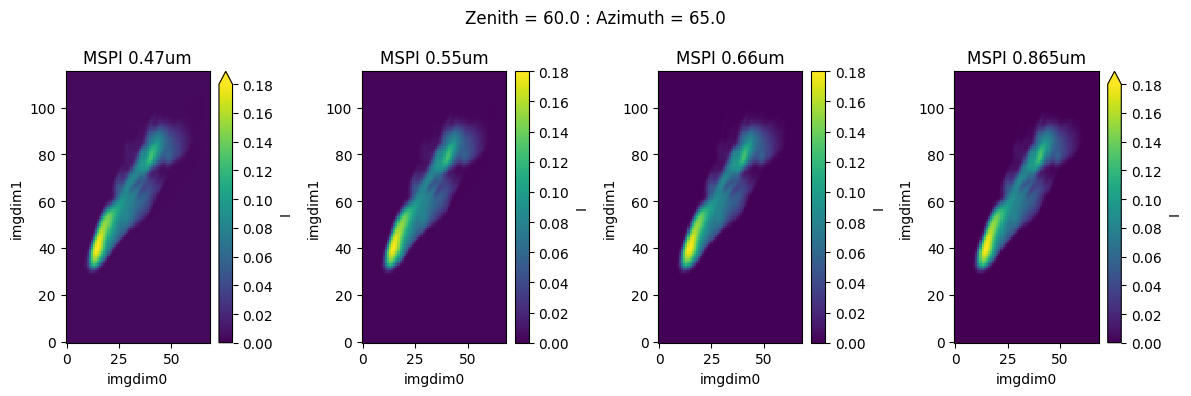

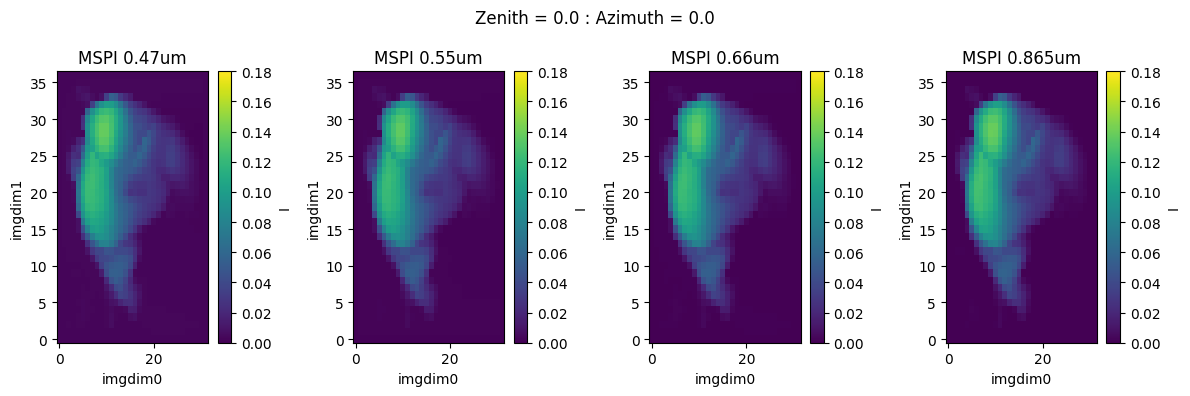

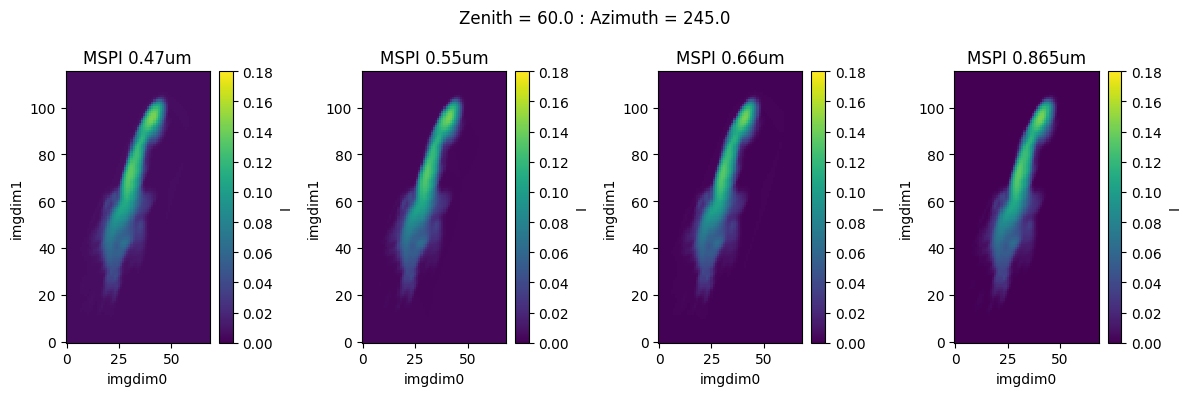

In [15]:
#plot
for j,sensor_dict in enumerate(sensor_dicts):
    fig, axs = py.subplots(1, len(wavelengths), figsize=(12, 4))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[j]) + " : Azimuth = " + str(sensor_azimuth_list[j]))
    for instrument in sensor_dict:
        sensor_images = sensor_dict.get_images(instrument)
        for i,sensor in enumerate(sensor_images):
            sensor.I.T.plot(ax=axs[i], vmin=0, vmax=.18)
            axs[i].set_title(instrument + " " + str(wavelengths[i]) + "um")
        py.tight_layout()  # Adjust layout for better spacing
        py.show()

### TEST 865 plus SWIR

In [5]:
sensor_dicts = []
wavelengths = [.865, 1.240, 1.640, 2.130] 
sensor_zenith_list = [60.0, 0.0, 60.0]
sensor_azimuth_list = [65.0, 0.0, 65+180.0]

for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
    sensor_dict = at3d.containers.SensorsDict()
    for wavelength in wavelengths:
        sensor_dict.add_sensor('MSPI', 
                at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                         altitude='TOA', stokes='I'))
    sensor_dicts.append(sensor_dict)

In [6]:
mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=True
    )

making mie_table. . . may take a while.
making mie_table. . . may take a while.
making mie_table. . . may take a while.


In [7]:
# for wavelength in wavelengths:
#     mie_mono_tables[wavelength].to_netcdf(path='../mie_tables/' + str(wavelength) + '_mie_table.nc')

In [8]:
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(5.0,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)
optical_properties = optical_property_generator(cloud_scatterer_on_rte_grid)

In [9]:
# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

In [10]:
solvers_dict = at3d.containers.SolversDict()
# note we could set solver dependent surfaces / sources / numerical_config here
# just as we have got solver dependent optical properties.

for wavelength in sensor_dicts[0].get_unique_solvers():
    medium = {
        'cloud': optical_properties[wavelength],
        'rayleigh':rayleigh_scattering[wavelength]
     }
    config = at3d.configuration.get_config()
    solvers_dict.add_solver(
        wavelength,
        at3d.solver.RTE(
            numerical_params=config,
            surface=at3d.surface.lambertian(0.0),
            source=at3d.source.solar(wavelength, 0.5,0.0),
            medium=medium,
            num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
        )                   
    )

In [11]:
%%time
for sensor_dict in sensor_dicts:
    # solve the 4 RTEs in parallel AND get the measurements.
    sensor_dict.get_measurements(solvers_dict, n_jobs=4, verbose=True)

CPU times: user 10min 2s, sys: 927 ms, total: 10min 3s
Wall time: 2min 40s


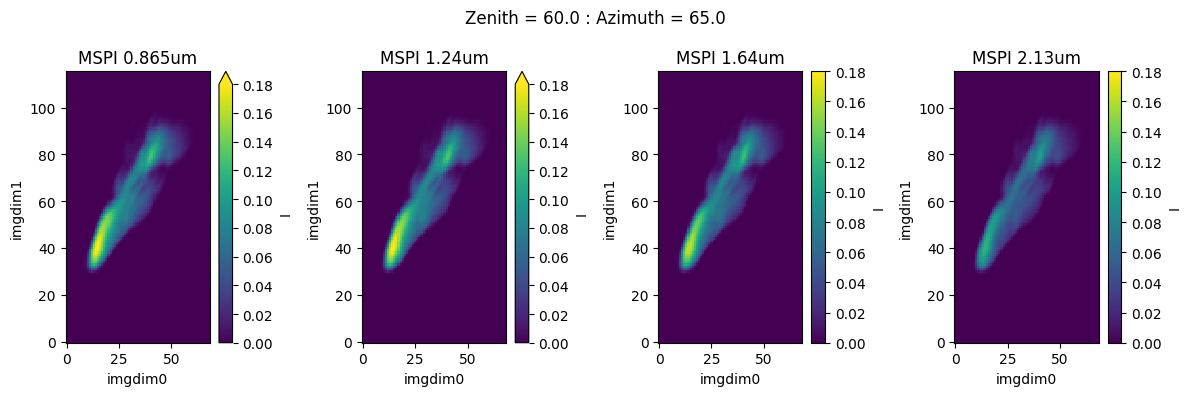

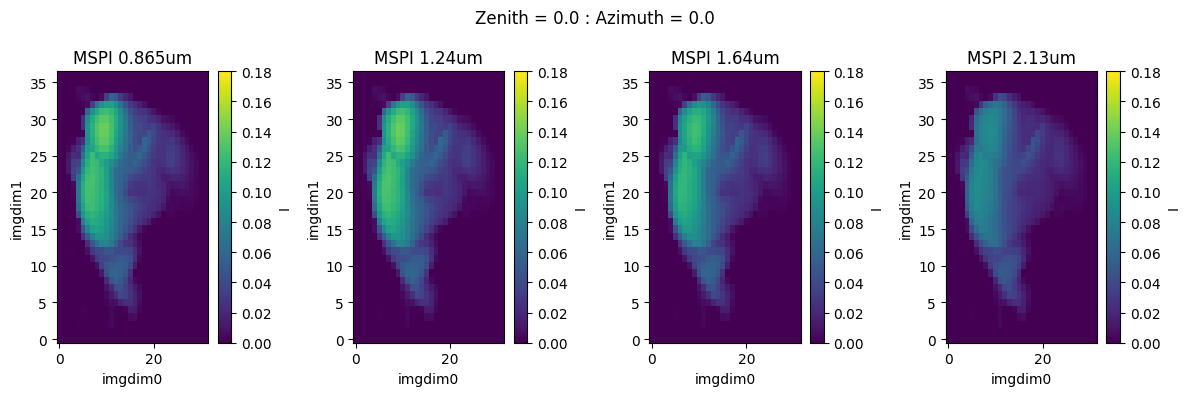

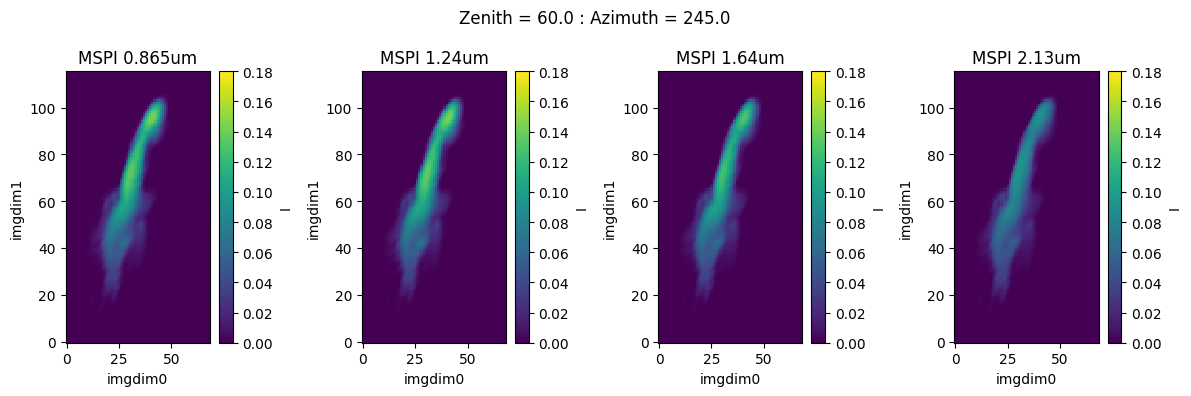

In [14]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
for j,sensor_dict in enumerate(sensor_dicts):
    fig, axs = py.subplots(1, len(wavelengths), figsize=(12, 4))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[j]) + " : Azimuth = " + str(sensor_azimuth_list[j]))
    for instrument in sensor_dict:
        sensor_images = sensor_dict.get_images(instrument)
        for i,sensor in enumerate(sensor_images):
            sensor.I.T.plot(ax=axs[i], vmin=0, vmax=.18, cmap=cmap)
            axs[i].set_title(instrument + " " + str(wavelengths[i]) + "um")
        py.tight_layout()  # Adjust layout for better spacing
        py.show()

### USE DIFFERENT R_e and LWC MULTIPLICITY

In [5]:
multiplicities = [1, 1.1, 1.5, 2.0]
cloud_scatterers = []
for multiplicity in multiplicities:
    temp_cloud_scatterer_on_rte_grid = cloud_scatterer_on_rte_grid.copy()
    temp_cloud_scatterer_on_rte_grid.reff.data = cloud_scatterer_on_rte_grid.reff.data * multiplicity
    temp_cloud_scatterer_on_rte_grid.density.data = cloud_scatterer_on_rte_grid.density.data * multiplicity
    cloud_scatterers.append(temp_cloud_scatterer_on_rte_grid)

In [6]:
sensor_dicts_2D_1 = []
wavelengths = [.470]#.865, 1.240, 1.640, 2.130] 
sensor_zenith_list = [60.0, 0.0, 60.0]
sensor_azimuth_list = [65.0, 0.0, 65+180.0]
for cloud_scatterer in cloud_scatterers:
    sensor_dicts = []
    for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
        sensor_dict = at3d.containers.SensorsDict()
        for wavelength in wavelengths:
            sensor_dict.add_sensor('MSPI', 
                    at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                             altitude='TOA', stokes='I'))
        sensor_dicts.append(sensor_dict)
    sensor_dicts_2D_1.append(sensor_dicts)

In [7]:
mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

In [8]:
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(5.0,45,40),
    veff=np.linspace(0.03,0.37,18),
)
optical_properties = []
for cloud_scatterer in cloud_scatterers:
    optical_properties.append(optical_property_generator(cloud_scatterer))

In [9]:
# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

In [10]:
solver_dicts_2D_1 = []
for i, sensor_dicts in enumerate(sensor_dicts_2D_1):
    solver_dicts = []
    for sensor_dict in sensor_dicts:
        solvers_dict = at3d.containers.SolversDict()
        # note we could set solver dependent surfaces / sources / numerical_config here
        # just as we have got solver dependent optical properties.
        
        for wavelength in sensor_dict.get_unique_solvers():
            medium = {
                'cloud': optical_properties[i][wavelength],
                'rayleigh':rayleigh_scattering[wavelength]
             }
            config = at3d.configuration.get_config()
            solvers_dict.add_solver(
                wavelength,
                at3d.solver.RTE(
                    numerical_params=config,
                    surface=at3d.surface.lambertian(0.0),
                    source=at3d.source.solar(wavelength, 0.5,0.0),
                    medium=medium,
                    num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
                )                   
            )
        solver_dicts.append(solvers_dict)
    solver_dicts_2D_1.append(solver_dicts)

In [11]:
%%time
for i, sensor_dicts in enumerate(sensor_dicts_2D_1):
    for j, sensor_dict in enumerate(sensor_dicts):
        # solve the 4 RTEs in parallel AND get the measurements.
        sensor_dict.get_measurements(solver_dicts_2D_1[i][j], n_jobs=4, verbose=True)

CPU times: user 27min 38s, sys: 4.6 s, total: 27min 42s
Wall time: 27min 29s


In [14]:
print(sensor_images)

[<xarray.Dataset>
Dimensions:  (imgdim0: 69, imgdim1: 116)
Dimensions without coordinates: imgdim0, imgdim1
Data variables:
    x        (imgdim0, imgdim1) float64 0.0 0.0 0.0 0.0 ... 1.36 1.36 1.36 1.36
    y        (imgdim0, imgdim1) float64 0.0 0.02 0.04 0.06 ... 2.26 2.28 2.3
    mu       (imgdim0, imgdim1) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    phi      (imgdim0, imgdim1) float64 1.134 1.134 1.134 ... 1.134 1.134 1.134
    I        (imgdim0, imgdim1) float64 0.004307 0.004307 ... 0.004307 0.004307]


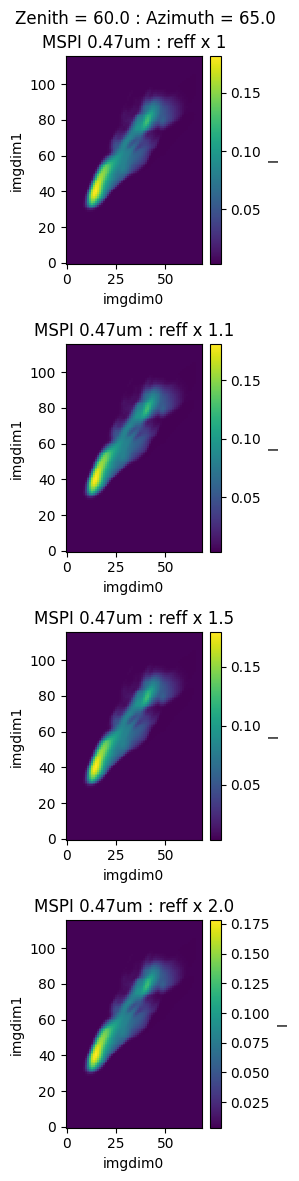

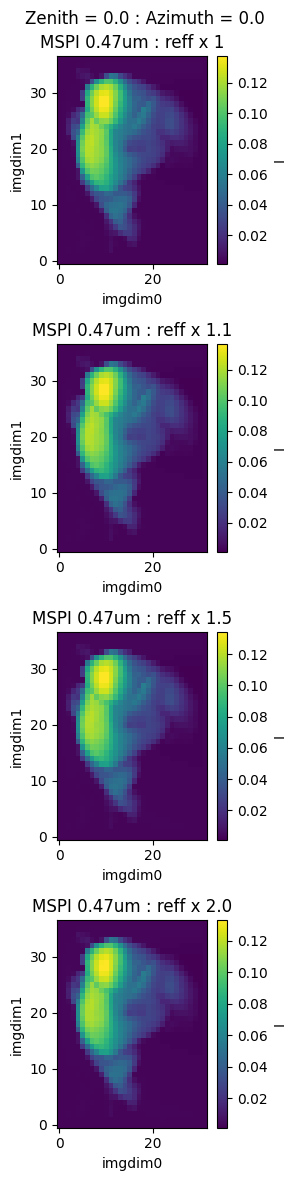

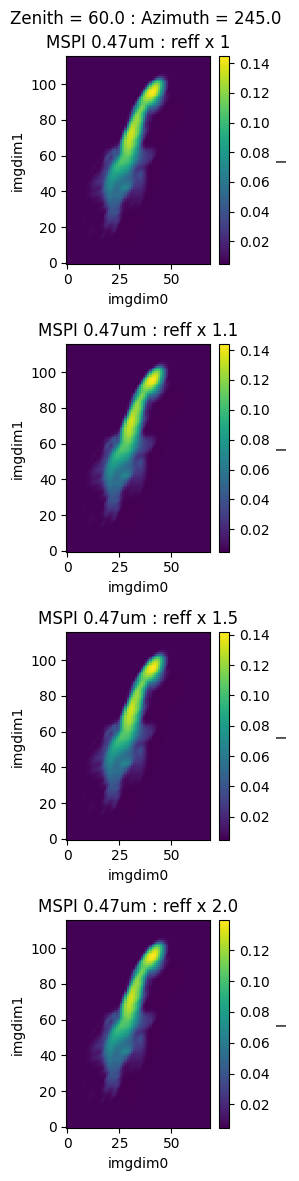

In [17]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
transpose = np.swapaxes(sensor_dicts_2D_1, 0, 1) # sensor_dicts_2D : reff x angle x wavelength | transpose : angle x reff x wavelength
for i,sensor_dicts in enumerate(transpose):
    fig, axs = py.subplots(len(multiplicities), len(wavelengths), figsize=(3, 12))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    for j,sensor_dict in enumerate(sensor_dicts):
        for instrument in sensor_dict:
            sensor_images = sensor_dict.get_images(instrument)
            for k,sensor in enumerate(sensor_images):
                sensor.I.T.plot(ax=axs[j])#, vmin=.000001, vmax=.005, cmap=cmap)
                axs[j].set_title(instrument + " " + str(wavelengths[k]) + "um : " + "reff x " + str(multiplicities[j]))
    py.tight_layout()  # Adjust layout for better spacing
    py.show()

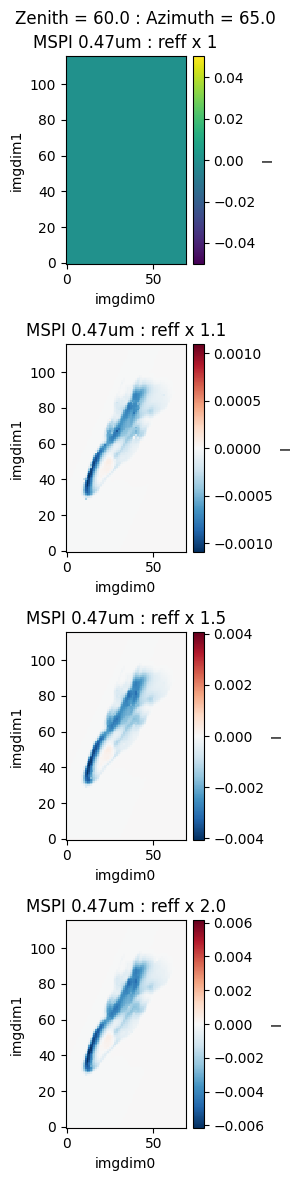

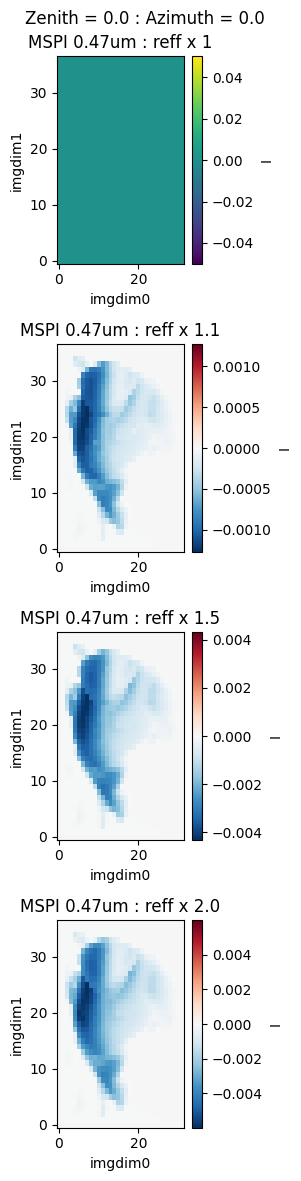

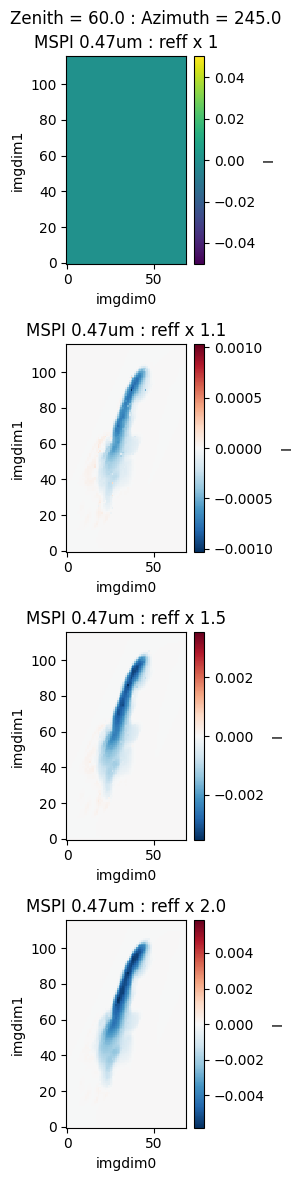

In [20]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
transpose = np.swapaxes(sensor_dicts_2D_1, 0, 1) # sensor_dicts_2D : reff x angle x wavelength | transpose : angle x reff x wavelength
for i,sensor_dicts in enumerate(transpose):
    fig, axs = py.subplots(len(multiplicities), len(wavelengths), figsize=(3, 12))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    base = sensor_dicts[0]
    base_images = base.get_images("MSPI")
    for j,sensor_dict in enumerate(sensor_dicts):
        for instrument in sensor_dict:
            sensor_images = sensor_dict.get_images(instrument)
            for k,sensor in enumerate(sensor_images):
                (sensor.I.T-base_images[k].I.T).plot(ax=axs[j])#, vmin=.000001, vmax=.005, cmap=cmap)
                axs[j].set_title(instrument + " " + str(wavelengths[k]) + "um : " + "reff x " + str(multiplicities[j]))
    py.tight_layout()  # Adjust layout for better spacing
    py.show()

In [21]:
%%time
for i, sensor_dicts in enumerate(sensor_dicts_2D):
    for j, sensor_dict in enumerate(sensor_dicts):
        # solve the 4 RTEs in parallel AND get the measurements.
        sensor_dict.get_measurements(solver_dicts_2D[i][j], n_jobs=4, verbose=True)

CPU times: user 1h 53min 11s, sys: 14.3 s, total: 1h 53min 25s
Wall time: 30min 29s


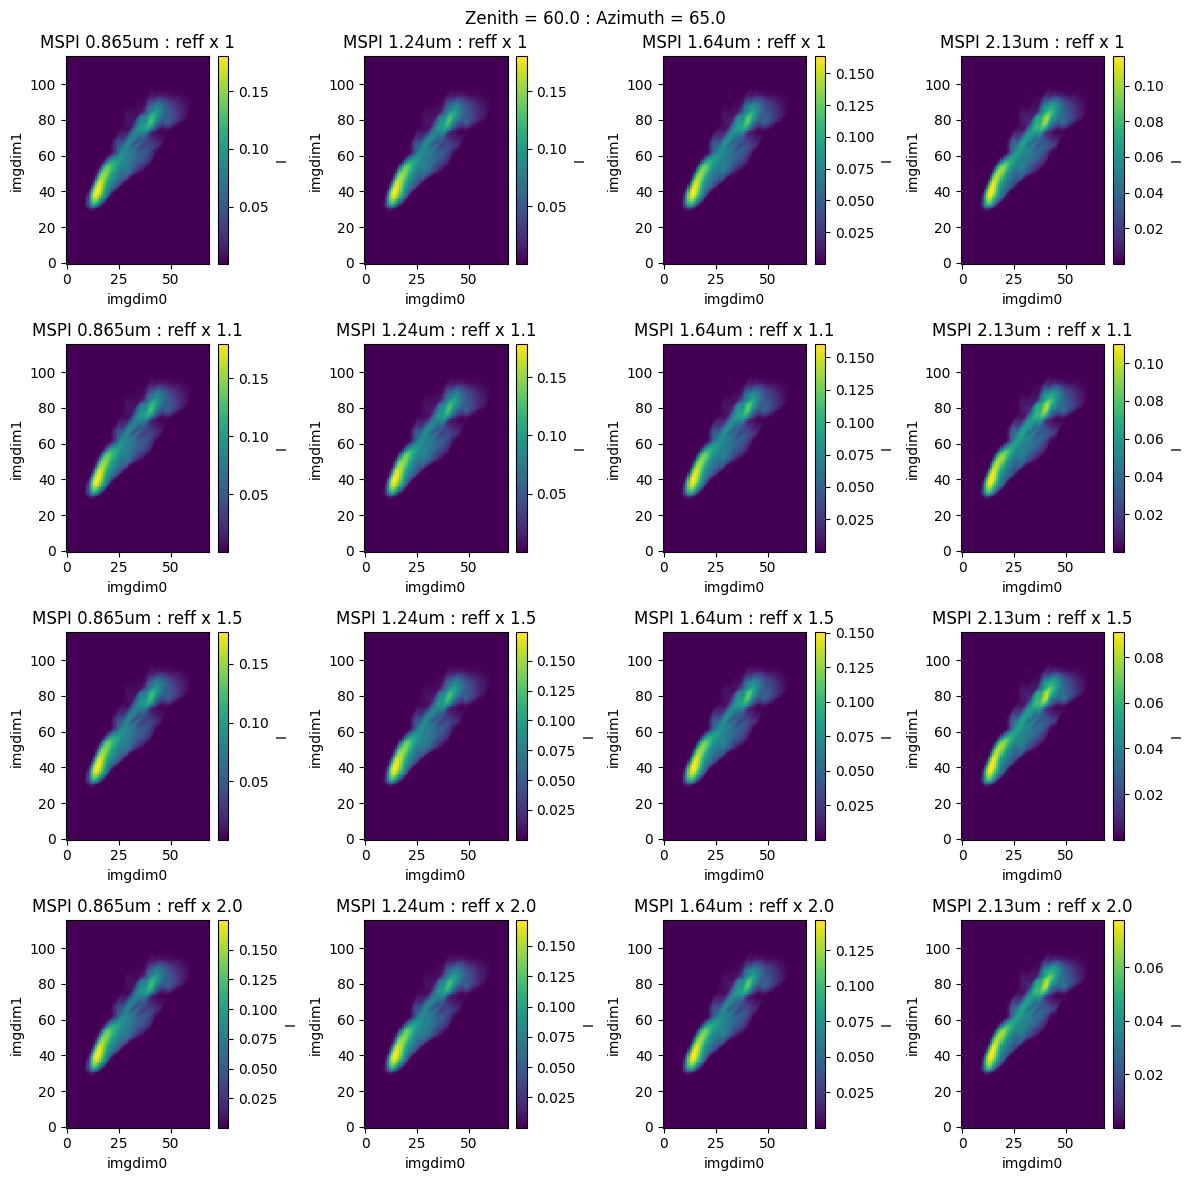

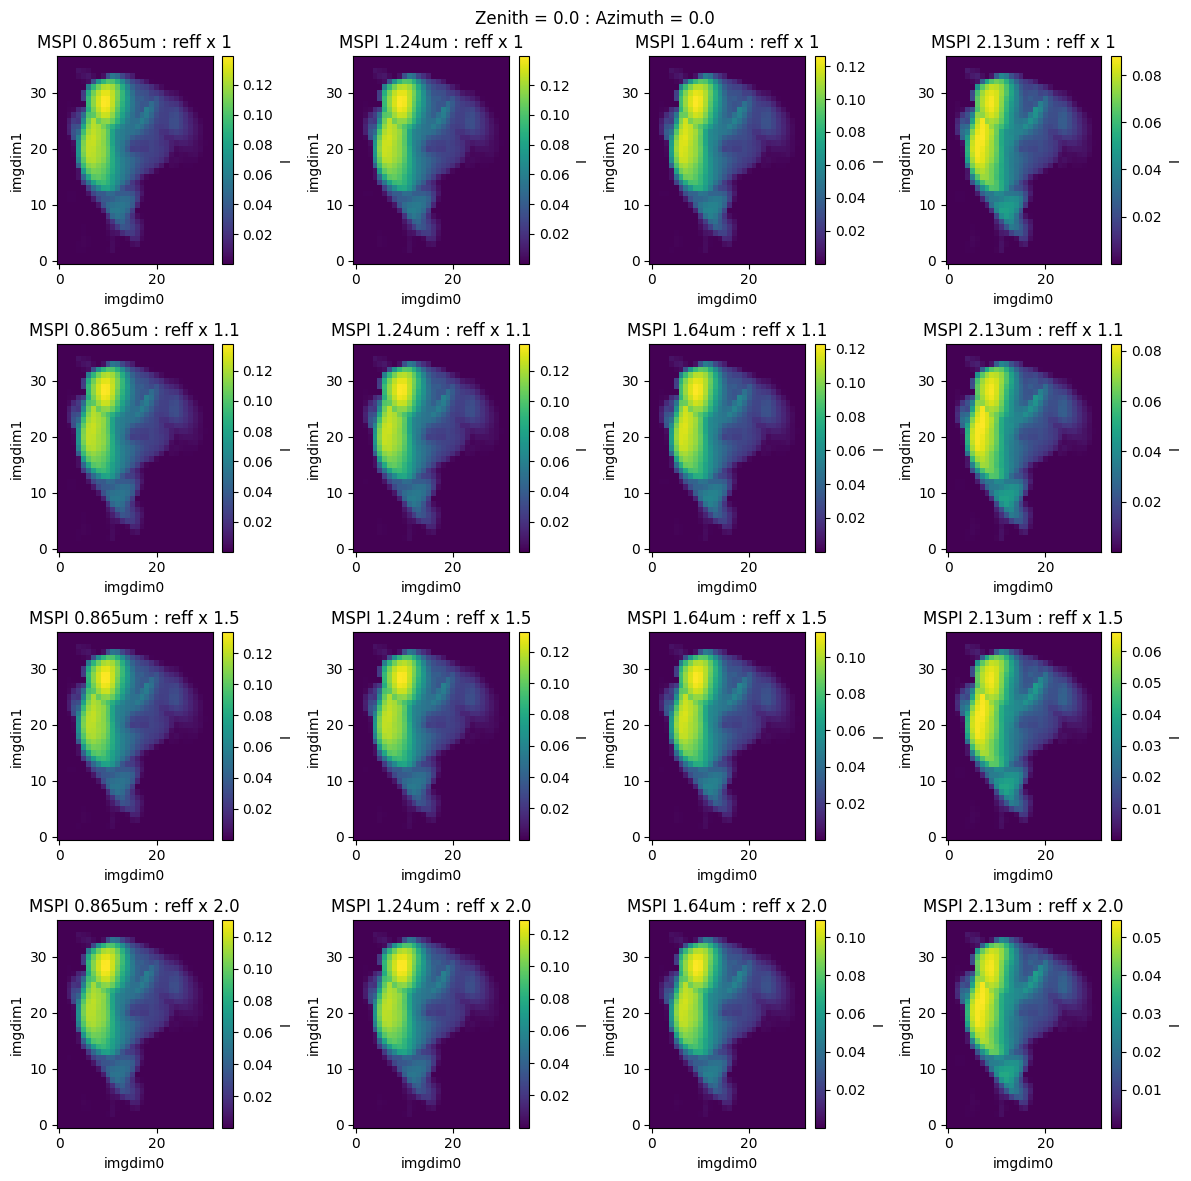

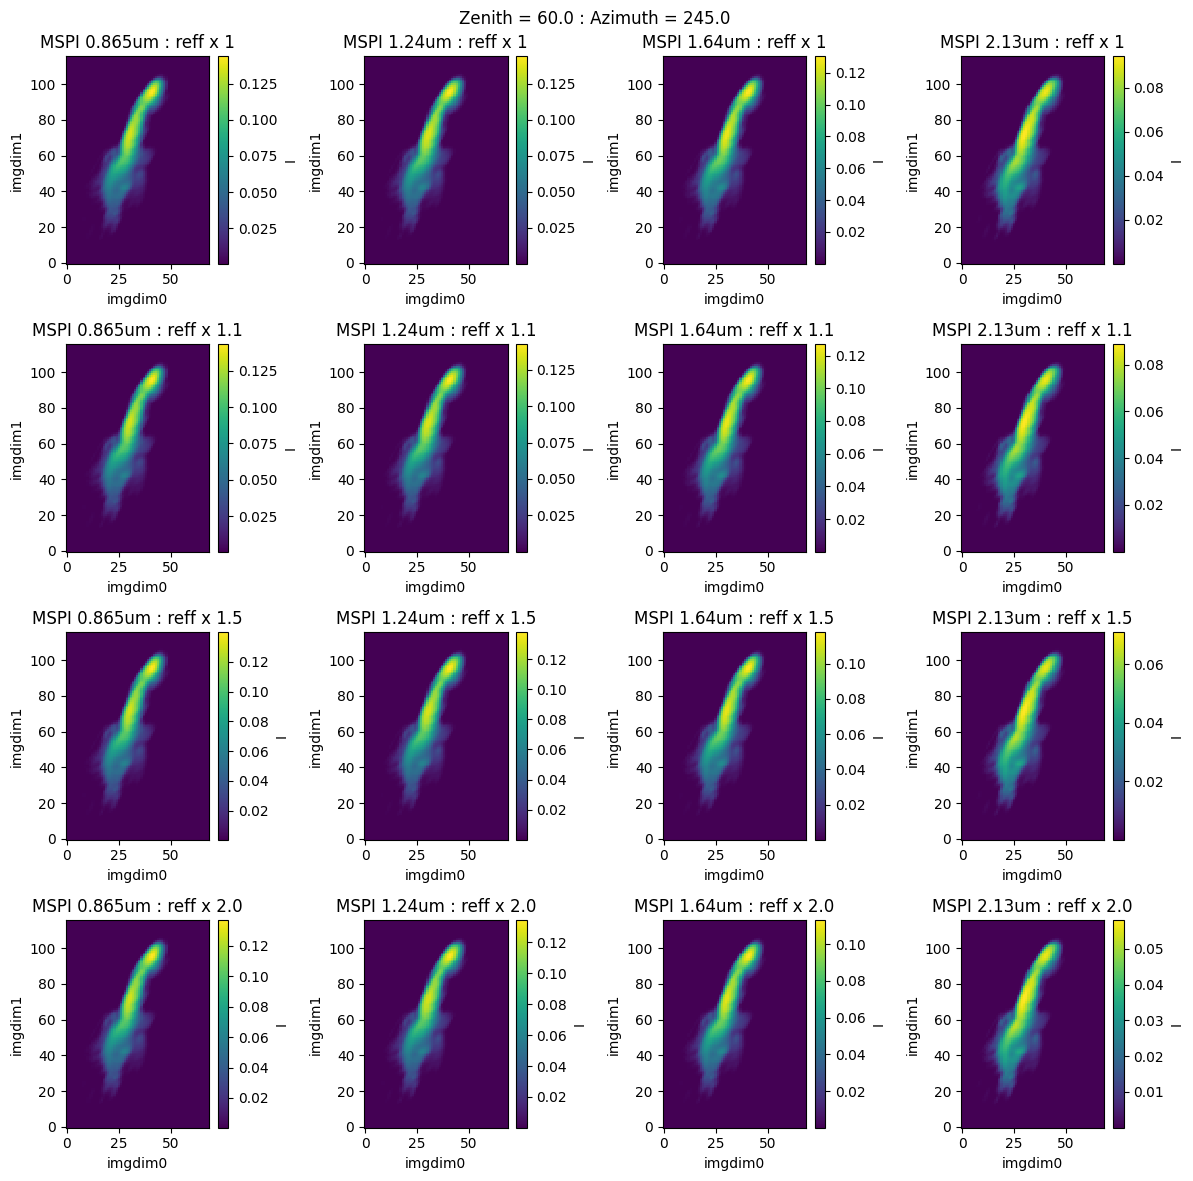

In [26]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
transpose = np.swapaxes(sensor_dicts_2D, 0, 1) # sensor_dicts_2D : reff x angle x wavelength | transpose : angle x reff x wavelength
for i,sensor_dicts in enumerate(transpose):
    fig, axs = py.subplots(len(multiplicities), len(wavelengths), figsize=(12, 12))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    for j,sensor_dict in enumerate(sensor_dicts):
        for instrument in sensor_dict:
            sensor_images = sensor_dict.get_images(instrument)
            for k,sensor in enumerate(sensor_images):
                sensor.I.T.plot(ax=axs[j, k])#, vmin=.000001, vmax=.005, cmap=cmap)
                axs[j,k].set_title(instrument + " " + str(wavelengths[k]) + "um : " + "reff x " + str(multiplicities[j]))
    py.tight_layout()  # Adjust layout for better spacing
    py.show()

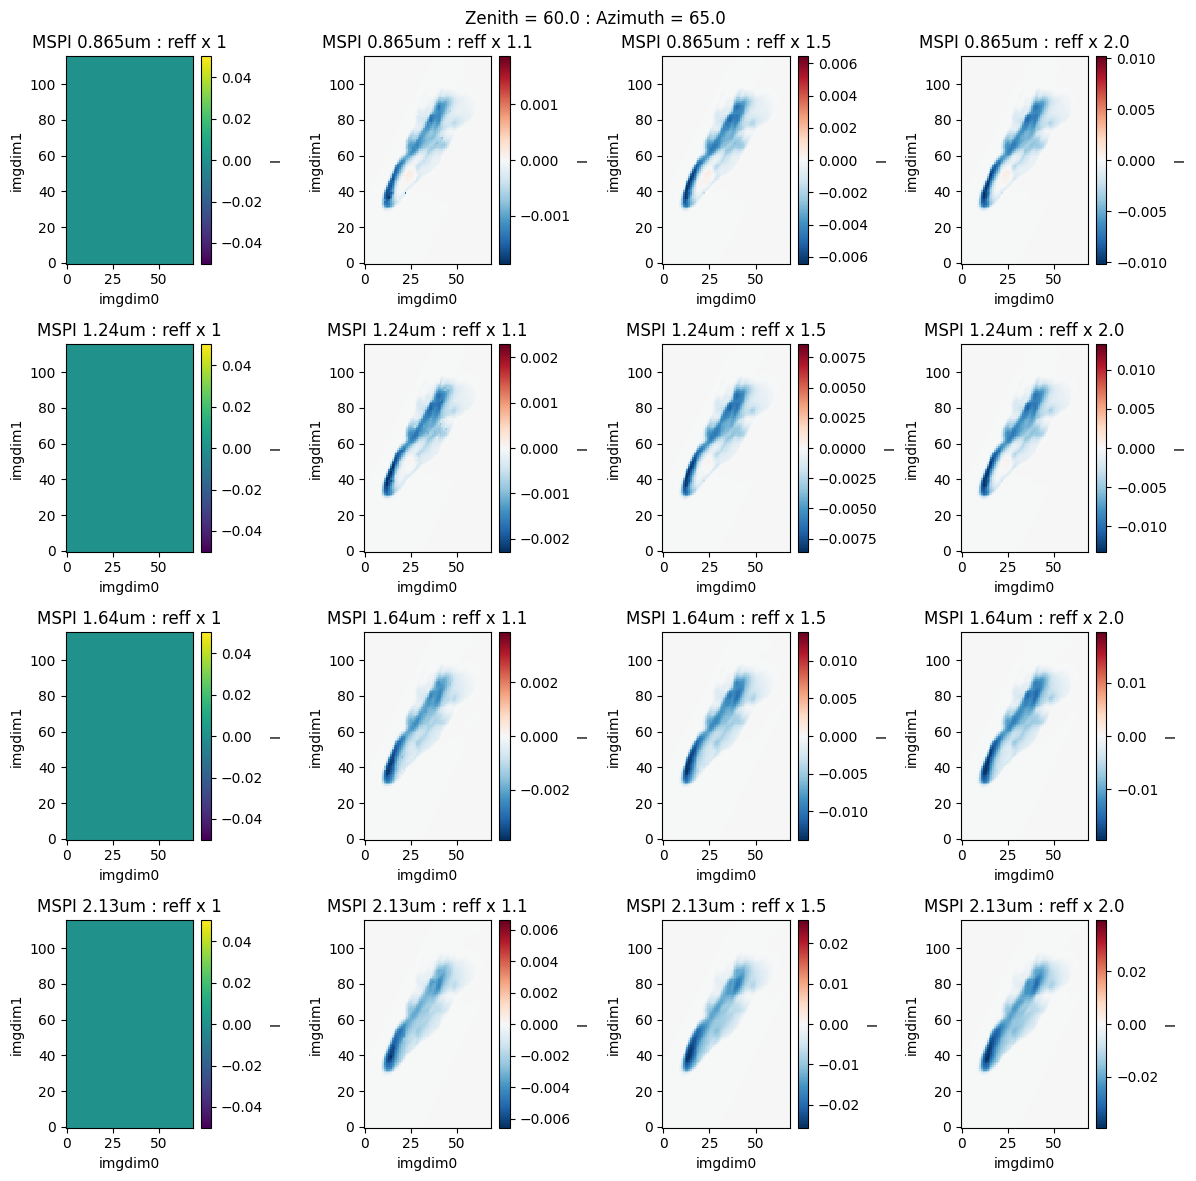

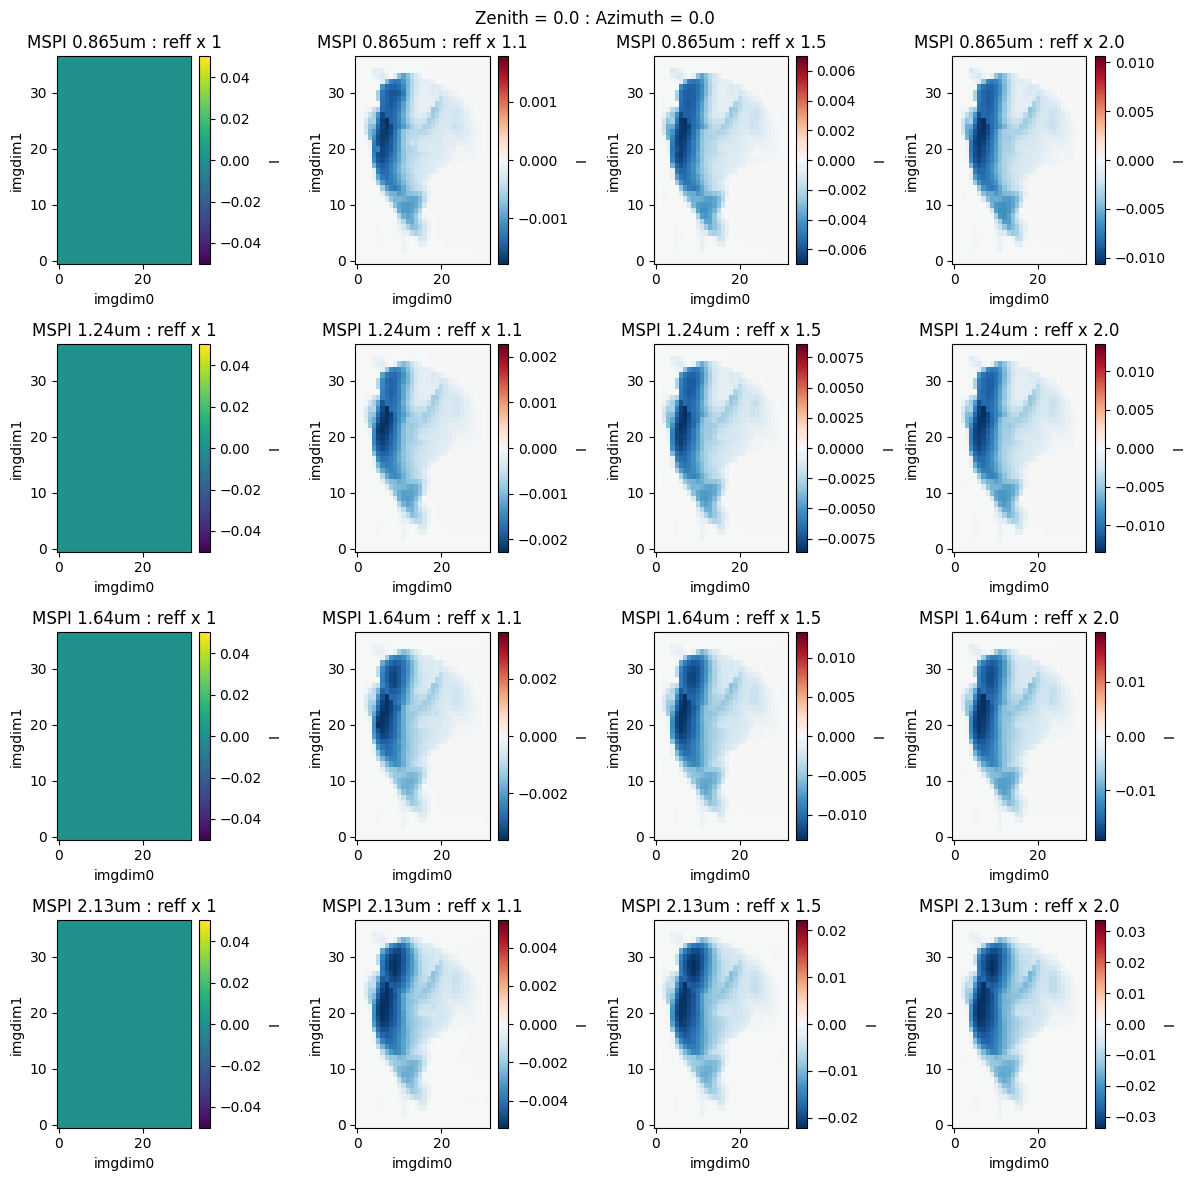

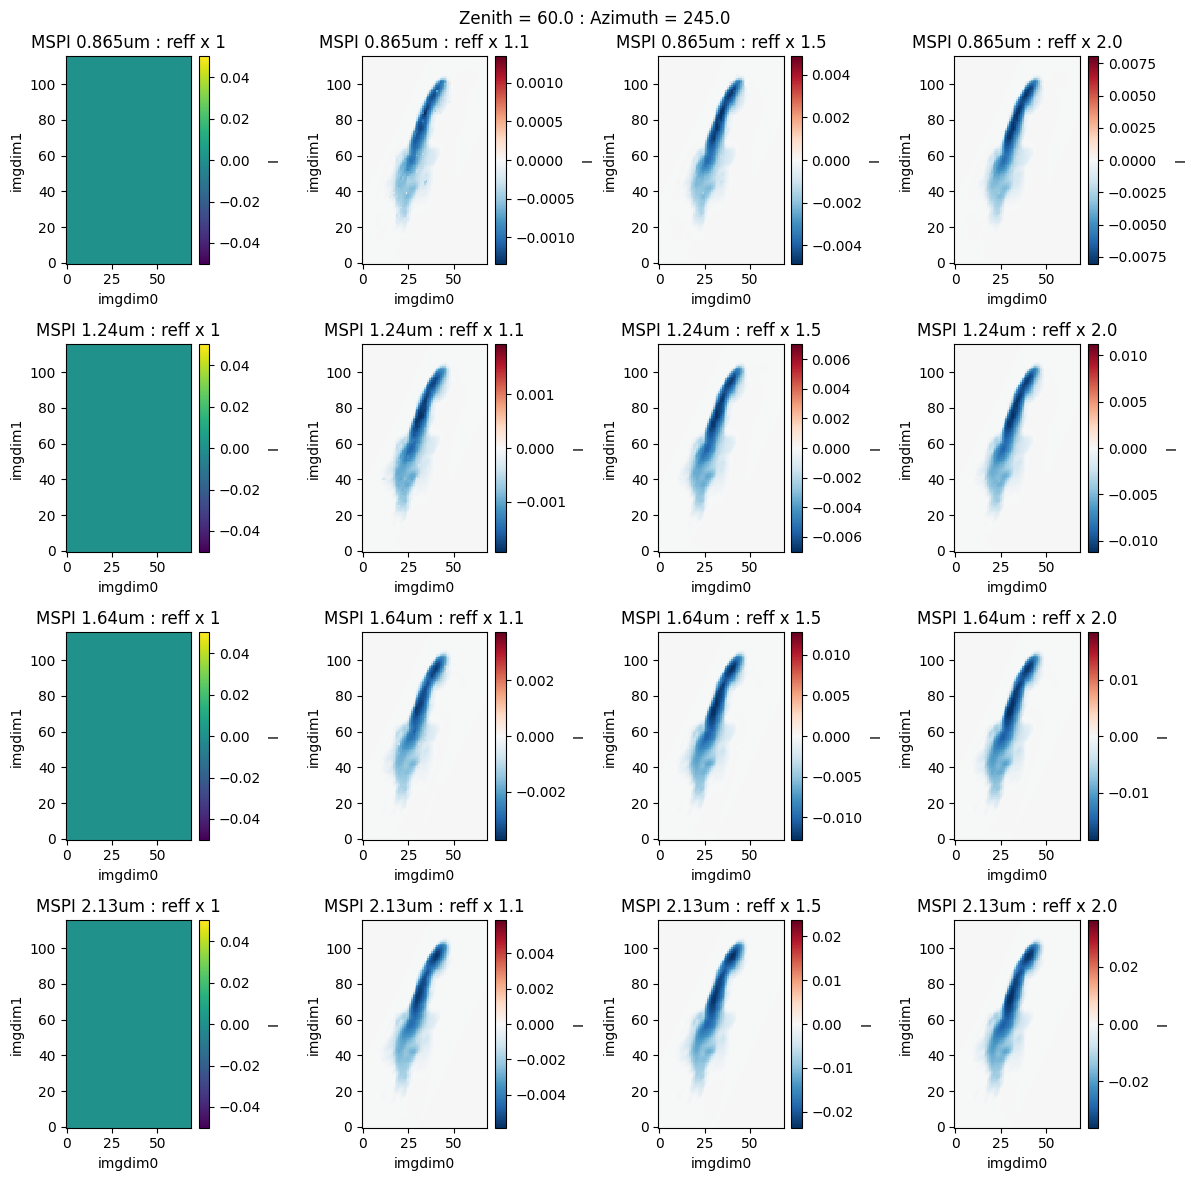

In [38]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
transpose = np.swapaxes(sensor_dicts_2D, 0, 1) # sensor_dicts_2D : reff x angle x wavelength | transpose : angle x reff x wavelength
for i,sensor_dicts in enumerate(transpose):
    fig, axs = py.subplots(len(multiplicities), len(wavelengths), figsize=(12, 12))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    base = sensor_dicts[0]
    base_images = base.get_images("MSPI")
    for j,sensor_dict in enumerate(sensor_dicts):
        for instrument in sensor_dict:
            sensor_images = sensor_dict.get_images(instrument)
            for k,image in enumerate(sensor_images):
                (image.I.T-base_images[k].I.T).plot(ax=axs[k, j])#, vmin=.000001, vmax=.005, cmap=cmap)
                axs[k, j].set_title(instrument + " " + str(wavelengths[k]) + "um : " + "reff x " + str(multiplicities[j]))
    py.tight_layout()  # Adjust layout for better spacing
    py.show()

### Inspect Rainbow

In [ ]:
cos_solar_zenith = np.cos(np.radians([60, 45, 0, 45, 60]))
solar_azimuth = [0, 0, 0, 180, 180]
wavelengths = [470, 550, 660, 865] 
sensor_zenith = 26.1
sensor_azimuth = 65.0


sensor_dict = at3d.containers.SensorsDict()
for wavelength in wavelengths:
    sensor_dict.add_sensor('MSPI', 
            at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, sensor_azimuth, sensor_zenith,
                                     altitude='TOA', stokes='I'))

In [ ]:
mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

In [ ]:
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(5.0,45,40),
    veff=np.linspace(0.03,0.37,18),
)
optical_properties = optical_property_generator(cloud_scatterer_on_rte_grid)

In [ ]:
# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

In [ ]:
solvers_dicts = []
for cos_zen, azi in zip(cos_solar_zenith, solar_azimuth):
    solvers_dict = at3d.containers.SolversDict()
    # note we could set solver dependent surfaces / sources / numerical_config here
    # just as we have got solver dependent optical properties.
    
    for wavelength in sensor_dicts[0].get_unique_solvers():
        medium = {
            'cloud': optical_properties[wavelength],
            'rayleigh':rayleigh_scattering[wavelength]
         }
        config = at3d.configuration.get_config()
        solvers_dict.add_solver(
            wavelength,
            at3d.solver.RTE(
                numerical_params=config,
                surface=at3d.surface.lambertian(0.0),
                source=at3d.source.solar(wavelength, cos_zen,azi),
                medium=medium,
                num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
            )                   
        )
        solver_dicts.append(solvers_dict)

In [ ]:
%%time
for i, sensor_dicts in enumerate(sensor_dicts_2D):
    for j, sensor_dict in enumerate(sensor_dicts):
        # solve the 4 RTEs in parallel AND get the measurements.
        sensor_dict.get_measurements(solvers_dict, n_jobs=4, verbose=True)